In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 
import os
from os.path import join
from glob import glob
import sys
from typing import Optional, List, Dict, Union
from collections import Counter
import random
from tqdm import tqdm

sys.path.append("../genev2/")
from ProteinEmbedding import ProteinEmbeddings
from GraphEmbeddings import GraphEmbeddings
from DNAEmbeddings import DNAEmbeddings
from IsolateDB import IsolateDB
from graph import build_graph_from_edges, laplacian_eigenvectors

import h5py
import sqlite3
import faiss
import cudf
import cupy as cp
from cuml.cluster import AgglomerativeClustering, HDBSCAN
from cuml import KMeans
from cuml.manifold import UMAP
from cuml.decomposition import PCA
from cuml.preprocessing import StandardScaler

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Subset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, average_precision_score

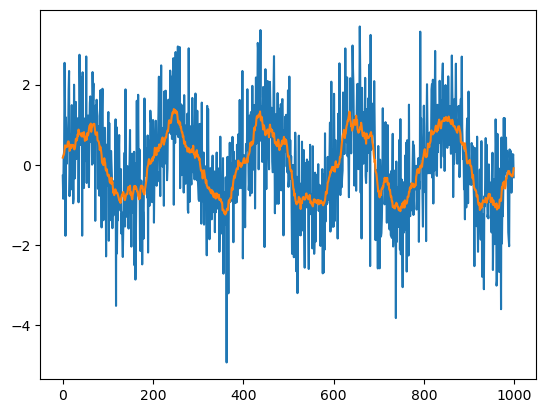

In [3]:

def moving_average(x, N):
    # Convolve with a length-N box
    return np.convolve(x, np.ones(N)/N, mode='same')

# Usage
signal = np.random.randn(1000) + np.sin(2*np.pi*5*np.linspace(0,1,1000))
smoothed = moving_average(signal, N=20)
plt.plot(signal)
plt.plot(smoothed)

In [4]:
cluster_path = "/orange/sai.zhang/khoa/repos/prophage/data/cluster_map.tsv"
embeddings_path = "/orange/sai.zhang/khoa/repos/prophage/data/protein_embeddings.h5"
virus_path = "/orange/sai.zhang/khoa/repos/prophage/data/virome_db.csv"
genome_path = "/orange/sai.zhang/khoa/repos/prophage/data/genome_db_new.csv"
isolate_path = "/orange/sai.zhang/khoa/repos/prophage/data/isolates_db_full.sqlite"
vclust_path = "/orange/sai.zhang/khoa/repos/prophage/data/cluster_ani30_qcov50_rcov50_set_cover.tsv"
edges_path = "/orange/sai.zhang/khoa/repos/prophage/data/ecoli_ppi_edges.txt"
ecoli_embeddings = "/orange/sai.zhang/khoa/repos/prophage/data/ecoli.esmc_embeddings.pkl"
dna_embeddings =  "/orange/sai.zhang/khoa/repos/prophage/data/dna_features.h5"
dna_embeddings_path =  "/orange/sai.zhang/khoa/repos/prophage/data/compressed_dnafeat.h5"
protein_embeddings_path = "/orange/sai.zhang/khoa/repos/prophage/data/compressed_protein_embeddings.h5"
graph_embeddings_path = "/orange/sai.zhang/khoa/repos/prophage/data/graph_embeddings.h5"
graph_protein_cluster_map = "/orange/sai.zhang/khoa/repos/prophage/data/protein_cluster_graph_map.npy"

In [5]:
proteinEmbeddings = ProteinEmbeddings(
    embeddings_path=protein_embeddings_path,
    cluster_map_path=cluster_path
)
dnaEmbeddings = DNAEmbeddings(
    embeddings_path=dna_embeddings_path
)
graph_tokens = np.load(graph_protein_cluster_map, allow_pickle=True).item()
graphEmbeddings = GraphEmbeddings(graph_embeddings_path, cluster_path, graph_tokens)
db = IsolateDB(isolate_path)

In [6]:
df_genome = db.get_genome_table()
df_virome = db.get_virome_table()

df_genome.to_csv("/orange/sai.zhang/khoa/repos/prophage/data/genome_db_0528.csv", index = None)
df_virome.to_csv("/orange/sai.zhang/khoa/repos/prophage/data/virome_db_0528.csv", index = None)

In [7]:
num_species = len(df_genome["species"].unique())
zero_prophage = num_species - len(df_virome["species"].unique())

In [8]:
num_viruses = df_virome.groupby("species").agg({"seq_name": lambda x: len(set(x))})["seq_name"].to_list()

In [9]:
prophage_counts = num_viruses + [0]*zero_prophage

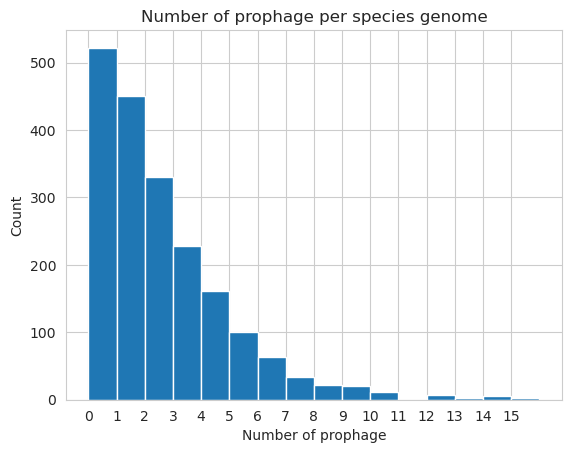

In [13]:
import seaborn as sns
sns.set_style("whitegrid")
plt.hist(prophage_counts, bins = 16)
plt.xlabel("Number of prophage")
plt.xticks(np.arange(0,16), np.arange(0,16))
plt.ylabel("Count")
plt.title("Number of prophage per species genome")
plt.savefig("../data/images/prophage_per_genome.png")

In [18]:
len(df_virome["species"].unique())

1436

In [14]:
df_genome.groupby("species").agg({"prophage"})


In [70]:
class ViromeDataset(Dataset):
    def __init__(
        self,
        db,
        protein_embeddings_source,
        dna_embeddings_source,
        graph_embeddings_source,
        max_sequence_length: int,
        padding_value: float = 0.0
    ):
        """
        Preload and pad/truncate all samples to a fixed length for fast indexing.

        Args:
            db: IsolateDB instance
            protein_embeddings_source: ProteinEmbeddings instance
            dna_embeddings_source: DNAEmbeddings instance
            graph_embeddings_source: GraphEmbeddings instance
            max_sequence_length: fixed length to pad/truncate sequences
            padding_value: value to use for padding
        """
        self.max_sequence_length = max_sequence_length
        self.padding_value = padding_value

        # Store references
        self.db = db
        self.protein_source = protein_embeddings_source
        self.dna_source = dna_embeddings_source
        self.graph_source = graph_embeddings_source

        # Load vocabulary mappings
        self.record_ids = db.get_all_record_ids()
        self.type_categories = db.get_all_types()
        self.biotype_categories = db.get_all_biotypes()
        self.type_to_index = {cat: idx for idx, cat in enumerate(self.type_categories)}
        self.biotype_to_index = {cat: idx for idx, cat in enumerate(self.biotype_categories)}

        # Preload and pad all samples
        self.samples = []
        for record_id in self.record_ids:
            features = db.get_record_feature(record_id)
            seq_length = len(features['type'])
            # filter out seq_len < 2
            if seq_length < 2:
                continue
            # 1D categorical tracks
            type_indices = torch.tensor(
                [self.type_to_index.get(t, 0) for t in features['type']],
                dtype=torch.long
            )
            biotype_indices = torch.tensor(
                [self.biotype_to_index.get(b, 0) for b in features['biotype']],
                dtype=torch.long
            )
            raw_strand = torch.tensor(features['strand'], dtype=torch.long)
            strand_indices = ((raw_strand + 1) // 2).clamp(0, 1)

            # Homolog count track (float), apply log-scaling
            homologs_raw = torch.tensor(features['homologs'], dtype=torch.float32)
            homologs_scaled = torch.log1p(homologs_raw)

            # Label track
            label_tensor = torch.full((seq_length,), -1, dtype=torch.long)
            pos_mask = torch.tensor(features['prophage']) == 1
            neg_mask = torch.tensor(features['species_prev']) > 250
            label_tensor[neg_mask] = 0
            for idx, product in enumerate(features['product']):
                if 'hypothetical protein' in str(product).lower():
                    label_tensor[idx] = -1
            label_tensor[pos_mask] = 1

            # Embedding tracks
            # Protein embeddings
            protein_dim = self.protein_source.embedding_dim
            protein_matrix = np.zeros((seq_length, protein_dim), dtype=np.float32)
            valid_positions = [i for i, pid in enumerate(features['protein_id']) if pid]
            if valid_positions:
                valid_pids = [features['protein_id'][i] for i in valid_positions]
                batch_embs = self.protein_source.get_embeddings(valid_pids)
                for i, emb in zip(valid_positions, batch_embs):
                    protein_matrix[i] = emb
            protein_embeddings = torch.tensor(protein_matrix, dtype=torch.float32)

            # DNA embeddings
            dna_matrix = self.dna_source.get_embeddings(
                features['locus_tag'],
                [record_id] * seq_length,
                features['protein_id']
            )
            dna_embeddings = torch.tensor(dna_matrix, dtype=torch.float32)

            # Graph embeddings
            graph_dim = self.graph_source.embedding_dim
            graph_matrix = np.zeros((seq_length, graph_dim), dtype=np.float32)
            if valid_positions:
                graph_batch = self.graph_source.get_embeddings(valid_pids)
                for i, emb in zip(valid_positions, graph_batch):
                    graph_matrix[i] = emb
            graph_embeddings = torch.tensor(graph_matrix, dtype=torch.float32)

            # Padding/truncation helpers
            def pad_1d(tensor_1d: torch.Tensor) -> torch.Tensor:
                length = tensor_1d.size(0)
                if length < self.max_sequence_length:
                    return F.pad(
                        tensor_1d,
                        (0, self.max_sequence_length - length),
                        value=self.padding_value
                    )
                return tensor_1d[: self.max_sequence_length]

            def pad_2d(tensor_2d: torch.Tensor) -> torch.Tensor:
                length, dim = tensor_2d.size()
                if length < self.max_sequence_length:
                    return F.pad(
                        tensor_2d,
                        (0, 0, 0, self.max_sequence_length - length),
                        value=self.padding_value
                    )
                return tensor_2d[: self.max_sequence_length, :]

            # Apply padding/truncation
            type_track      = pad_1d(type_indices)
            biotype_track   = pad_1d(biotype_indices)
            strand_track    = pad_1d(strand_indices)
            homologs_track  = pad_1d(homologs_scaled)
            label_track     = pad_1d(label_tensor)
            protein_track   = pad_2d(protein_embeddings)
            dna_track       = pad_2d(dna_embeddings)
            graph_track     = pad_2d(graph_embeddings)

            # Padding mask: True for padded positions
            actual_len = min(seq_length, self.max_sequence_length)
            padding_mask = torch.arange(self.max_sequence_length) >= actual_len

            self.samples.append({
                'type_track': type_track,
                'biotype_track': biotype_track,
                'strand_track': strand_track,
                'homologs_track': homologs_track,
                'protein_embeddings': protein_track,
                'dna_embeddings': dna_track,
                'graph_embeddings': graph_track,
                'labels': label_track,
                'padding_mask': padding_mask,
                'record_id': record_id
            })
    
    def get_test_index(self):
        """
        Returns indices of samples that have NO positive prophage labels (i.e., label==1).
        """
        return [
            idx
            for idx, sample in enumerate(self.samples)
            # `.any().item()` checks if any position == 1
            if not (sample['labels'] == 1).any().item()
        ]

    def get_train_index(self):
        """
        Returns indices of samples that have AT LEAST one positive prophage label (i.e., label==1).
        """
        return [
            idx
            for idx, sample in enumerate(self.samples)
            if (sample['labels'] == 1).any().item()
        ]
    
    def get_record_ids(self):
        record_ids = []
        for sample in self.samples:
            record_ids.append(sample["record_id"])
            
        return record_ids
    
    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> dict:
        return self.samples[index]

In [15]:
class PositionalEncoding(nn.Module):
    """
    Fixed sinusoidal positional encoding.
    Adds a (batch, seq_len, d_model) pe tensor to the input embeddings.
    """
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32) *
            -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape (1, max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]


class TransformerClassifier(nn.Module):
    """
    Transformer encoder with sinusoidal positional encoding + token classification head.
    Accepts:
      - type_ids:      (B, L)
      - biotype_ids:   (B, L)
      - strand_ids:    (B, L)
      - homologs:      (B, L) float track (log-scaled)
      - protein_emb:   (B, L, D1)
      - dna_emb:       (B, L, D2)
      - graph_emb:     (B, L, D3)
      - mask:          (B, L) bool padding mask (True = pad)
    """
    def __init__(
        self,
        type_vocab_size: int,
        biotype_vocab_size: int,
        strand_vocab_size: int,
        track_embed_dim: int,
        strand_embed_dim: int,
        homologs_embed_dim: int,
        protein_embed_dim: int,
        dna_embed_dim: int,
        graph_embed_dim: int,
        embed_dim: int = 300,
        num_heads: int = 6,
        ffn_dim: int = 1024,
        num_layers: int = 4,
        dropout: float = 0.1,
        max_seq_len: int = 10000
    ):
        super().__init__()
        # 1D track embeddings
        self.type_emb    = nn.Embedding(type_vocab_size,    track_embed_dim)
        self.biotype_emb = nn.Embedding(biotype_vocab_size, track_embed_dim)
        self.strand_emb  = nn.Embedding(strand_vocab_size,  strand_embed_dim)
        self.homologs_proj = nn.Linear(1, homologs_embed_dim)
        self.protein_embed_dim = protein_embed_dim
        self.dna_embed_dim = dna_embed_dim
        self.graph_embed_dim = graph_embed_dim
        
        # compute total feature dim
        total_feat_dim = (
              track_embed_dim   # type
            + track_embed_dim   # biotype
            + strand_embed_dim  # strand
            + homologs_embed_dim# homologs
            + protein_embed_dim
            + dna_embed_dim
            + graph_embed_dim
        )
        
        self.protein_finetune =  nn.Linear(self.protein_embed_dim, self.protein_embed_dim)
        self.dna_finetune =  nn.Linear(self.dna_embed_dim, self.dna_embed_dim)
        self.graph_finetune =  nn.Linear(self.graph_embed_dim, self.graph_embed_dim)

        self.input_norm = nn.LayerNorm(total_feat_dim)
        self.input_proj = nn.Linear(total_feat_dim, embed_dim)

        # positional encoding
        self.pos_encoder = PositionalEncoding(d_model=embed_dim, max_len=max_seq_len)

        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # final classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim//2),
            nn.ReLU(),
            nn.Linear(embed_dim//2, 2)
        )

    def forward(
        self,
        type_ids: torch.LongTensor,
        biotype_ids: torch.LongTensor,
        strand_ids: torch.LongTensor,
        homologs: torch.FloatTensor,
        protein_emb: torch.FloatTensor,
        dna_emb: torch.FloatTensor,
        graph_emb: torch.FloatTensor,
        mask: torch.BoolTensor = None
    ) -> torch.Tensor:
        # embed 1D tracks
        te = self.type_emb(type_ids)    # (B, L, track_embed_dim)
        be = self.biotype_emb(biotype_ids)
        # remap strand
        strand_idx = ((strand_ids + 1) // 2).clamp(0, self.strand_emb.num_embeddings-1)
        se = self.strand_emb(strand_idx)  # (B, L, strand_embed_dim)
        # homologs projection
        he = self.homologs_proj(homologs.unsqueeze(-1))  # (B, L, homologs_embed_dim)

        # concat all features
        protein_emb = self.protein_finetune(protein_emb)
        dna_emb = self.dna_finetune(dna_emb)
        graph_emb = self.graph_finetune(graph_emb)

        x = torch.cat([te, be, se, he, protein_emb, dna_emb, graph_emb], dim=-1)
        x = self.input_norm(x)
        x = self.input_proj(x)             # (B, L, embed_dim)

        # add sin/cos positional encodings
        x = self.pos_encoder(x)            # (B, L, embed_dim)

        # transformer
        out = self.transformer(x, src_key_padding_mask=mask)  # (B, L, embed_dim)

        # per-token logits
        logits = self.classifier(out)      # (B, L, 2)
        return logits


    
# class MaskedCrossEntropyLoss(nn.Module):
#     """
#     Standard CE over two classes, but ignores:
#      - labels == -1  (unknown)
#      - padding_mask == True
#     """
#     def __init__(self):
#         super().__init__()
#         # we'll use ignore_index=-2 so any target == -2 is skipped
#         self.ce = nn.CrossEntropyLoss(ignore_index=-2, reduction='mean')

#     def forward(
#         self,
#         logits: torch.Tensor,        # (B, L, 2)
#         labels: torch.Tensor,        # (B, L), with -1 for unknown
#         padding_mask: torch.Tensor = None  # (B, L) bool
#     ) -> torch.Tensor:
#         B, L, C = logits.shape
#         # flatten to (B*L, C) and (B*L,)
#         flat_logits = logits.reshape(-1, C)
#         flat_labels = labels.reshape(-1)

#         # if we also want to ignore padded positions, overwrite those labels to -2
#         if padding_mask is not None:
#             flat_mask = padding_mask.reshape(-1)
#             flat_labels = flat_labels.masked_fill(flat_mask, -2)

#         # CE will skip any position where flat_labels == -1
#         return self.ce(flat_logits, flat_labels)

class MaskedCrossEntropyLoss(nn.Module):
    """
    Standard CE over two classes, but:
     - ignores padding (mask == True)
     - treats label == -1 (unknown) by biasing predictions toward a specified ratio
    """
    def __init__(
        self,
        unk_bias_ratio: float = 0.5,
        unk_weight: float = 1.0
    ):
        super().__init__()
        # ignore_index = -2 to skip padded positions
        self.ce = nn.CrossEntropyLoss(ignore_index=-2, reduction='mean')
        self.unk_bias_ratio = unk_bias_ratio
        self.unk_weight = unk_weight

    def forward(
        self,
        logits: torch.Tensor,         # (B, L, 2)
        labels: torch.Tensor,         # (B, L), unknown = -1
        padding_mask: torch.Tensor = None  # (B, L) bool
    ) -> torch.Tensor:
        B, L, C = logits.shape
        flat_logits = logits.view(-1, C)
        flat_labels = labels.view(-1)

        # apply padding mask
        if padding_mask is not None:
            flat_mask = padding_mask.view(-1)
            flat_labels = flat_labels.masked_fill(flat_mask, -2)

        # mask unknown (-1) as ignore_index too
        flat_labels = flat_labels.masked_fill(flat_labels == -1, -2)
        valid_known = (flat_labels != -2)
        if valid_known.sum() == 0:
            loss_main = 0.0
        else:
            # main CE over known labels
            loss_main = self.ce(flat_logits, flat_labels)

        # handle unknown positions (original labels == -1 before masking)
        unk_mask = (labels.view(-1) == -1)
        if padding_mask is not None:
            unk_mask &= ~padding_mask.view(-1)

        if unk_mask.any():
            # gather logits for unknown positions
            unk_logits = flat_logits[unk_mask]  # (N_unk, 2)
            # compute log-probs
            logp = F.log_softmax(unk_logits, dim=-1)  # (N_unk, 2)
            # target distribution [ratio for class0, 1-ratio for class1]
            t0 = self.unk_bias_ratio
            t1 = 1.0 - self.unk_bias_ratio
            # soft-cross-entropy: -sum(target * logp)
            loss_unk = -(t0 * logp[:,0] + t1 * logp[:,1]).mean()
            return loss_main + self.unk_weight * loss_unk
        return loss_main
    
# class MaskedCrossEntropyLoss(nn.Module):
#     """
#     Standard CE over two classes, but:
#      - ignores padding (mask == True)
#      - treats label == -1 (unknown) by biasing predictions toward a specified ratio
#      - returns zero‐loss (with valid grad) if a batch has no valid tokens
#     """
#     def __init__(
#         self,
#         unk_bias_ratio: float = 0.5,
#         unk_weight: float = 1.0
#     ):
#         super().__init__()
#         # we'll use ignore_index=-2 for both padding and unknown in the main CE
#         self.ce = nn.CrossEntropyLoss(ignore_index=-2, reduction='mean')
#         self.unk_bias_ratio = unk_bias_ratio
#         self.unk_weight = unk_weight

#     def forward(
#         self,
#         logits: torch.Tensor,         # (B, L, 2)
#         labels: torch.Tensor,         # (B, L), unknown = -1
#         padding_mask: torch.Tensor = None  # (B, L) bool, True = pad
#     ) -> torch.Tensor:
#         B, L, C = logits.shape
#         flat_logits = logits.view(-1, C)    # (B*L, 2)
#         flat_labels = labels.view(-1)       # (B*L,)

#         # build padding mask
#         if padding_mask is not None:
#             flat_pad = padding_mask.view(-1)
#         else:
#             flat_pad = torch.zeros_like(flat_labels, dtype=torch.bool)

#         # identify unknown positions before we mask them away
#         raw_labels = labels.view(-1)
#         unk_mask = (raw_labels == -1) & (~flat_pad)
#         num_unk = unk_mask.sum()

#         # now mask padding and unknown for the main CE
#         flat_labels = flat_labels.masked_fill(flat_pad, -2)
#         flat_labels = flat_labels.masked_fill(flat_labels == -1, -2)
#         main_mask = (flat_labels != -2)
#         num_main = main_mask.sum()

#         # if no tokens at all, return zero‐loss with a gradient path
#         if num_main == 0 and num_unk == 0:
#             print("NO LOSS")
#             return torch.tensor(0.0, device=logits.device, requires_grad=True)

#         # compute main CE if we have known labels
#         if num_main > 0:
#             loss_main = self.ce(flat_logits, flat_labels)
#         else:
#             # dummy zero‐loss
#             loss_main = torch.tensor(0.0, device=logits.device, requires_grad=True)

#         # compute unk‐bias loss if we have unknowns
#         if num_unk > 0:
#             unk_logits = flat_logits[unk_mask]            # (N_unk, 2)
#             logp = F.log_softmax(unk_logits, dim=-1)      # (N_unk, 2)
#             t0 = self.unk_bias_ratio
#             t1 = 1.0 - t0
#             loss_unk = -(t0 * logp[:, 0] + t1 * logp[:, 1]).mean()
#             # combine
#             if num_main > 0:
#                 return loss_main + self.unk_weight * loss_unk
#             else:
#                 # only unknown loss
#                 return self.unk_weight * loss_unk

#         # no unknowns, just return main loss
#         return loss_main

In [16]:
full_dataset = ViromeDataset(db, proteinEmbeddings, dnaEmbeddings, graphEmbeddings, max_sequence_length=10_000)

/orange/sai.zhang/khoa/repos/prophage/notebooks/../genev2/IsolateDB.py:149: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['species_prev'] = df['species_prev'].fillna(0.)
/orange/sai.zhang/khoa/repos/prophage/notebooks/../genev2/IsolateDB.py:150: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['homologs'] = df['homologs'].fillna(0.)


In [17]:
test_indices = full_dataset.get_test_index()
remaining_indices = full_dataset.get_train_index()
random.seed(1809)
random.shuffle(remaining_indices)
split_idx = int(0.7 * len(remaining_indices))
train_indices = remaining_indices[:split_idx]
val_indices   = remaining_indices[split_idx:]

In [18]:
train_dataset = Subset(full_dataset, train_indices)
val_dataset   = Subset(full_dataset, val_indices)
test_dataset  = Subset(full_dataset, test_indices)

In [19]:
# 1) Hyper-parameters
NUM_EPOCHS    = 10
BATCH_SIZE    = 16
MAX_SEQ_LEN   = 10_000
GRAD_CLIP     = 1.0
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [20]:
import psutil
def check_ram():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory used: {mem_info.rss / (1024 ** 3):.2f} GB")
check_ram()


Memory used: 74.82 GB


In [22]:
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, average_precision_score
import wandb

def train_val_loop(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    device,
    num_epochs,
    checkpoint_prefix="model",
    use_wandb: bool = False,
    max_grad_norm: float = None,
    scheduler=None              # e.g. a warm‐up or LR scheduler
):
    """
    Trains and validates the model, tracking per‐batch metrics and:
      - gradient clipping
      - NaN checks
      - wandb logging of loss, metrics, weight & grad norms

    Args:
        use_wandb: if True, logs metrics to Weights & Biases
        max_grad_norm: clip gradients to this L2 norm (optional)
        scheduler: lr scheduler (should be stepped after optimizer.step)
    """
    history = {
        'train': {k: [] for k in [
            'loss', 'true_pos', 'true_neg', 'pred_pos', 'pred_neg',
            'prec_pos', 'rec_pos', 'prec_neg', 'rec_neg',
            'ap_pos', 'ap_neg'
        ]},
        'val':   {k: [] for k in [
            'loss', 'true_pos', 'true_neg', 'pred_pos', 'pred_neg',
            'prec_pos', 'rec_pos', 'prec_neg', 'rec_neg',
            'ap_pos', 'ap_neg'
        ]}
    }

    global_step = 0
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_iter = iter(train_loader)
        val_iter   = iter(val_loader)
        num_batches = min(len(train_loader), len(val_loader))

        for batch_idx in range(num_batches):
            # --- Training Batch ---
            batch = next(train_iter)
            inputs = {
                'type_ids':    batch['type_track'].to(device),
                'biotype_ids': batch['biotype_track'].to(device),
                'strand_ids':  batch['strand_track'].to(device),
                'homologs':    batch['homologs_track'].to(device),
                'protein_emb': batch['protein_embeddings'].to(device),
                'dna_emb':     batch['dna_embeddings'].to(device),
                'graph_emb':   batch['graph_embeddings'].to(device),
                'mask':        batch['padding_mask'].to(device)
            }
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            logits = model(
                inputs['type_ids'], inputs['biotype_ids'], inputs['strand_ids'],
                inputs['homologs'], inputs['protein_emb'], inputs['dna_emb'], inputs['graph_emb'],
                mask=inputs['mask']
            )
            loss = loss_fn(logits, labels, inputs['mask'])
            if torch.isnan(loss):
                raise RuntimeError(f"NaN in loss at epoch {epoch}, batch {batch_idx}")

            loss.backward()

            # Gradient clipping
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Check for NaNs in grads
            for name, param in model.named_parameters():
                if param.grad is not None and torch.isnan(param.grad).any():
                    raise RuntimeError(f"NaN in grad for {name} at epoch {epoch}, batch {batch_idx}")

            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            # Compute metrics
            B, L, C = logits.shape
            probs = F.softmax(logits, dim=-1).view(-1, C)
            flat_labels = labels.view(-1)
            flat_mask   = inputs['mask'].view(-1)
            valid = (flat_labels != -1) & (~flat_mask)
            y_true   = flat_labels[valid].cpu().numpy()
            y_scores = probs[valid].detach().cpu().numpy()
            y_pred   = logits.argmax(dim=-1).view(-1)[valid].cpu().numpy()

            true_pos = (y_true == 1).sum()
            true_neg = (y_true == 0).sum()
            pred_pos = (y_pred == 1).sum()
            pred_neg = (y_pred == 0).sum()
            prec_pos = precision_score(y_true == 1, y_pred == 1, zero_division=0)
            rec_pos  = recall_score   (y_true == 1, y_pred == 1, zero_division=0)
            prec_neg = precision_score(y_true == 0, y_pred == 0, zero_division=0)
            rec_neg  = recall_score   (y_true == 0, y_pred == 0, zero_division=0)
            ap_pos   = average_precision_score(y_true == 1, y_scores[:,1])
            ap_neg   = average_precision_score(y_true == 0, y_scores[:,0])

            # Save to history
            h_train = history['train']
            for k, v in zip(
                ['loss','true_pos','true_neg','pred_pos','pred_neg',
                 'prec_pos','rec_pos','prec_neg','rec_neg','ap_pos','ap_neg'],
                [loss.item(),true_pos,true_neg,pred_pos,pred_neg,
                 prec_pos,rec_pos,prec_neg,rec_neg,ap_pos,ap_neg]
            ):
                h_train[k].append(v)

            # wandb logging
            if use_wandb:
                log_dict = {
                    'train/loss': loss.item(),
                    'train/prec_pos': prec_pos, 'train/rec_pos': rec_pos,
                    'train/prec_neg': prec_neg, 'train/rec_neg': rec_neg
                }
                # weight & grad norms
                for name, param in model.named_parameters():
                    log_dict[f'weights/{name}_norm'] = param.norm().item()
                    if param.grad is not None:
                        log_dict[f'grads/{name}_norm'] = param.grad.norm().item()
                wandb.log(log_dict, step=global_step)

            print(
                f"[Epoch {epoch:02d} Batch {batch_idx+1}/{num_batches}] "
                f"TRAIN loss={loss.item():.4f} "
                f"T+={true_pos} T-={true_neg} P+={pred_pos} P-={pred_neg} "
                f"Prec+={prec_pos:.3f} Rec+={rec_pos:.3f} "
                f"Prec-={prec_neg:.3f} Rec-={rec_neg:.3f} "
                f"AP+={ap_pos:.3f} AP-={ap_neg:.3f}"
            )

            global_step += 1

            # --- Validation Batch ---
            model.eval()
            with torch.no_grad():
                batch = next(val_iter)
                inputs = {
                    'type_ids':    batch['type_track'].to(device),
                    'biotype_ids': batch['biotype_track'].to(device),
                    'strand_ids':  batch['strand_track'].to(device),
                    'homologs':    batch['homologs_track'].to(device),
                    'protein_emb': batch['protein_embeddings'].to(device),
                    'dna_emb':     batch['dna_embeddings'].to(device),
                    'graph_emb':   batch['graph_embeddings'].to(device),
                    'mask':        batch['padding_mask'].to(device)
                }
                labels = batch['labels'].to(device)

                logits = model(
                    inputs['type_ids'], inputs['biotype_ids'], inputs['strand_ids'],
                    inputs['homologs'], inputs['protein_emb'], inputs['dna_emb'], inputs['graph_emb'],
                    mask=inputs['mask']
                )
                val_loss = loss_fn(logits, labels, inputs['mask'])
                if torch.isnan(val_loss):
                    raise RuntimeError(f"NaN in val loss at epoch {epoch}, batch {batch_idx}")

                B, L, C = logits.shape
                probs = F.softmax(logits, dim=-1).view(-1, C)
                flat_labels = labels.view(-1)
                flat_mask   = inputs['mask'].view(-1)
                valid = (flat_labels != -1) & (~flat_mask)
                y_true   = flat_labels[valid].cpu().numpy()
                y_scores = probs[valid].detach().cpu().numpy()
                y_pred   = logits.argmax(dim=-1).view(-1)[valid].cpu().numpy()

                true_pos = (y_true == 1).sum()
                true_neg = (y_true == 0).sum()
                pred_pos = (y_pred == 1).sum()
                pred_neg = (y_pred == 0).sum()
                prec_pos = precision_score(y_true == 1, y_pred == 1, zero_division=0)
                rec_pos  = recall_score   (y_true == 1, y_pred == 1, zero_division=0)
                prec_neg = precision_score(y_true == 0, y_pred == 0, zero_division=0)
                rec_neg  = recall_score   (y_true == 0, y_pred == 0, zero_division=0)
                ap_pos   = average_precision_score(y_true == 1, y_scores[:,1])
                ap_neg   = average_precision_score(y_true == 0, y_scores[:,0])

                h_val = history['val']
                for k, v in zip(
                    ['loss','true_pos','true_neg','pred_pos','pred_neg',
                     'prec_pos','rec_pos','prec_neg','rec_neg','ap_pos','ap_neg'],
                    [val_loss.item(),true_pos,true_neg,pred_pos,pred_neg,
                     prec_pos,rec_pos,prec_neg,rec_neg,ap_pos,ap_neg]
                ):
                    h_val[k].append(v)

                if use_wandb:
                    wandb.log({
                        'val/loss': val_loss.item(),
                        'val/prec_pos': prec_pos, 'val/rec_pos': rec_pos,
                        'val/prec_neg': prec_neg, 'val/rec_neg': rec_neg,
                        'val/lr': optimizer.param_groups[0]['lr']
                    }, step=global_step)

                print(
                    f"[Epoch {epoch:02d} Batch {batch_idx+1}/{num_batches}] "
                    f" VAL loss={val_loss.item():.4f} "
                    f"T+={true_pos} T-={true_neg} P+={pred_pos} P-={pred_neg} "
                    f"Prec+={prec_pos:.3f} Rec+={rec_pos:.3f} "
                    f"Prec-={prec_neg:.3f} Rec-={rec_neg:.3f} "
                    f"AP+={ap_pos:.3f} AP-={ap_neg:.3f}"
                )

            model.train()

        # end-of-epoch checkpoint  
        ckpt_path = f"{checkpoint_prefix}{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict':    model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
        }, ckpt_path)
        print(f">>> Epoch {epoch} complete. Saved checkpoint: {ckpt_path}")

    return history


In [23]:
import torch
from transformers import get_linear_schedule_with_warmup
import wandb

# 1) Initialize W&B
wandb.init(
    project="virome-transformer",
    name="model_d512_h4_l8",
    config={
        "track_embed_dim": 8,
        "strand_embed_dim": 2,
        "homologs_embed_dim": 2,
        "embed_dim": 512,
        "num_heads": 4,
        "ffn_dim": 512,
        "num_layers": 4,
        "dropout": 0.1,
        "lr": 1e-4,
        "batch_size": train_loader.batch_size,
        "epochs": 40,
        "max_grad_norm": 0.1,
        "warmup_ratio": 0.05
    }
)

# 2) Build model, loss, optimizer
model = TransformerClassifier(
    type_vocab_size    = len(full_dataset.type_categories),
    biotype_vocab_size = len(full_dataset.biotype_categories),
    strand_vocab_size  = 2,
    track_embed_dim    = 8,
    strand_embed_dim   = 2,
    homologs_embed_dim = 2,
    protein_embed_dim  = proteinEmbeddings.embedding_dim,
    dna_embed_dim      = dnaEmbeddings.embedding_dim,
    graph_embed_dim    = graphEmbeddings.embedding_dim,
    embed_dim          = 512,
    num_heads          = 4,
    ffn_dim            = 512,
    num_layers         = 4,
    dropout            = 0.1,
    max_seq_len        = 10_000
).to(DEVICE)

loss_fn   = MaskedCrossEntropyLoss(unk_bias_ratio = 0.9, unk_weight = 1.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=wandb.config.lr, weight_decay=0.00001)

# 3) Create a linear‐warmup + decay scheduler
total_steps = len(train_loader) * wandb.config.epochs
warmup_steps = int(total_steps * wandb.config.warmup_ratio)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# # 4) Run training/validation loop with W&B, gradient clipping, and warm‐up
# history = train_val_loop(
#     model,
#     train_loader,
#     val_loader,
#     optimizer,
#     loss_fn,
#     DEVICE,
#     num_epochs=wandb.config.epochs,
#     checkpoint_prefix="model_d512_h4_l8",
#     use_wandb=True,
#     max_grad_norm=wandb.config.max_grad_norm,
#     scheduler=scheduler
# )


/blue/sai.zhang/khoang99.stanford/.conda/envs/faiss_1.8.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khoang99 (khoang99-stanford-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.finish()

In [37]:
import torch, gc
wandb.finish()
del model, optimizer, train_loader, val_loader  # whatever holds tensors
gc.collect()
torch.cuda.empty_cache()

In [29]:
best_model = TransformerClassifier(
    type_vocab_size    = len(full_dataset.type_categories),
    biotype_vocab_size = len(full_dataset.biotype_categories),
    strand_vocab_size  = 2,
    track_embed_dim    = 8,
    strand_embed_dim   = 2,
    homologs_embed_dim = 2,
    protein_embed_dim  = proteinEmbeddings.embedding_dim,
    dna_embed_dim      = dnaEmbeddings.embedding_dim,
    graph_embed_dim    = graphEmbeddings.embedding_dim,
    embed_dim          = 512,
    num_heads          = 4,
    ffn_dim            = 512,
    num_layers         = 4,
    dropout            = 0.1,
    max_seq_len        = 10_000
).to(DEVICE)

In [30]:
best_model.load_state_dict(torch.load("model_d512_h4_l830.pt")["model_state_dict"])

/scratch/local/4033470/ipykernel_493351/2758200059.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("model_d512_h4_l830.pt")["model_

<All keys matched successfully>

In [24]:
def plot_history(history):
    
    start = 10
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set(style="whitegrid")
    train = history['train']
    val   = history['val']
    epochs = list(range(1, len(train['loss'])+1))
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))

    # Loss
    sns.lineplot(x=epochs[start:], y=train['loss'][start:], ax=axes[0,0], label='Train Loss')
    sns.lineplot(x=epochs[start:], y=val['loss'][start:],   ax=axes[0,0], label='Val Loss')
    axes[0,0].set_title('Loss over Batches')

    # PR-AUC
    sns.lineplot(x=epochs[start:], y=train['ap_pos'][start:], ax=axes[0,1], label='Train PR-AUC Virus')
    sns.lineplot(x=epochs[start:], y=val['ap_pos'][start:],   ax=axes[0,1], label='Val PR-AUC Virus')
    sns.lineplot(x=epochs[start:], y=train['ap_neg'][start:], ax=axes[0,1], label='Train PR-AUC Bacteria')
    sns.lineplot(x=epochs[start:], y=val['ap_neg'][start:],   ax=axes[0,1], label='Val PR-AUC Bacteria')
    axes[0,1].set_title('PR-AUC per Class')

    # Precision
    sns.lineplot(x=epochs[start:], y=train['prec_pos'][start:], ax=axes[1,0], label='Train Precision Virus')
    sns.lineplot(x=epochs[start:], y=val['prec_pos'][start:],   ax=axes[1,0], label='Val Precision Virus')
    sns.lineplot(x=epochs[start:], y=train['prec_neg'][start:], ax=axes[1,0], label='Train Precision Bacteria')
    sns.lineplot(x=epochs[start:], y=val['prec_neg'][start:],   ax=axes[1,0], label='Val Precision Bacteria')
    axes[1,0].set_title('Precision per Class')

    # Recall
    sns.lineplot(x=epochs[start:], y=train['rec_pos'][start:], ax=axes[1,1], label='Train Recall Virus')
    sns.lineplot(x=epochs[start:], y=val['rec_pos'][start:],   ax=axes[1,1], label='Val Recall Virus')
    sns.lineplot(x=epochs[start:], y=train['rec_neg'][start:], ax=axes[1,1], label='Train Recall Bacteria')
    sns.lineplot(x=epochs[start:], y=val['rec_neg'][start:],   ax=axes[1,1], label='Val Recall Bacteria')
    axes[1,1].set_title('Recall per Class')

    # True vs Predicted Counts
    sns.lineplot(x=epochs[start:], y=np.array(train['pred_pos'])[start:] - np.array(train['true_pos'])[start:],\
                 ax=axes[2,0], label='Train True Virus Residuals')
    sns.lineplot(x=epochs[start:], y=np.array(val['pred_pos'])[start:] - np.array(val['true_pos'])[start:],\
                 ax=axes[2,0], label='Val True Virus Residuals')

    axes[2,0].set_title('Virus Residuals')

    sns.lineplot(x=epochs[start:], y=np.array(train['pred_neg'])[start:] - np.array(train['true_neg'])[start:],\
                 ax=axes[2,1], label='Train True Bacteria Residuals')
    sns.lineplot(x=epochs[start:], y=np.array(val['pred_neg'])[start:] - np.array(val['true_neg'])[start:],\
                 ax=axes[2,1], label='Val True Bacteria Residuals')

    axes[2,1].set_title('Bacteria Residuals')

    plt.tight_layout()
    plt.show()

# To visualize:
plot_history(history)

NameError: name 'history' is not defined

In [ ]:
def plot_history(history):
    
    start = 10
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set(style="whitegrid")
    train = history['train']
    val   = history['val']
    epochs = list(range(1, len(train['loss'])+1))
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))

    # Loss
    sns.lineplot(x=epochs[start:], y=train['loss'][start:], ax=axes[0,0], label='Train Loss')
    sns.lineplot(x=epochs[start:], y=val['loss'][start:],   ax=axes[0,0], label='Val Loss')
    axes[0,0].set_title('Loss over Batches')

    # PR-AUC
    sns.lineplot(x=epochs[start:], y=train['ap_pos'][start:], ax=axes[0,1], label='Train PR-AUC Virus')
    sns.lineplot(x=epochs[start:], y=val['ap_pos'][start:],   ax=axes[0,1], label='Val PR-AUC Virus')
    sns.lineplot(x=epochs[start:], y=train['ap_neg'][start:], ax=axes[0,1], label='Train PR-AUC Bacteria')
    sns.lineplot(x=epochs[start:], y=val['ap_neg'][start:],   ax=axes[0,1], label='Val PR-AUC Bacteria')
    axes[0,1].set_title('PR-AUC per Class')

    # Precision
    sns.lineplot(x=epochs[start:], y=train['prec_pos'][start:], ax=axes[1,0], label='Train Precision Virus')
    sns.lineplot(x=epochs[start:], y=val['prec_pos'][start:],   ax=axes[1,0], label='Val Precision Virus')
    sns.lineplot(x=epochs[start:], y=train['prec_neg'][start:], ax=axes[1,0], label='Train Precision Bacteria')
    sns.lineplot(x=epochs[start:], y=val['prec_neg'][start:],   ax=axes[1,0], label='Val Precision Bacteria')
    axes[1,0].set_title('Precision per Class')

    # Recall
    sns.lineplot(x=epochs[start:], y=train['rec_pos'][start:], ax=axes[1,1], label='Train Recall Virus')
    sns.lineplot(x=epochs[start:], y=val['rec_pos'][start:],   ax=axes[1,1], label='Val Recall Virus')
    sns.lineplot(x=epochs[start:], y=train['rec_neg'][start:], ax=axes[1,1], label='Train Recall Bacteria')
    sns.lineplot(x=epochs[start:], y=val['rec_neg'][start:],   ax=axes[1,1], label='Val Recall Bacteria')
    axes[1,1].set_title('Recall per Class')

    # True vs Predicted Counts
    sns.lineplot(x=epochs[start:], y=np.array(train['pred_pos'])[start:] - np.array(train['true_pos'])[start:],\
                 ax=axes[2,0], label='Train True Virus Residuals')
    sns.lineplot(x=epochs[start:], y=np.array(val['pred_pos'])[start:] - np.array(val['true_pos'])[start:],\
                 ax=axes[2,0], label='Val True Virus Residuals')

    axes[2,0].set_title('Virus Residuals')

    sns.lineplot(x=epochs[start:], y=np.array(train['pred_neg'])[start:] - np.array(train['true_neg'])[start:],\
                 ax=axes[2,1], label='Train True Bacteria Residuals')
    sns.lineplot(x=epochs[start:], y=np.array(val['pred_neg'])[start:] - np.array(val['true_neg'])[start:],\
                 ax=axes[2,1], label='Val True Bacteria Residuals')

    axes[2,1].set_title('Bacteria Residuals')

    plt.tight_layout()
    plt.show()

# To visualize:
plot_history(history)

In [ ]:
plot_history(history)

In [25]:
def plot_token_labels(
    model,
    loader,
    device,
    num_samples: int = 5,
    max_length: int = None,
    title: str = ""
):
    """
    Stack token-level heatmaps of true vs predicted labels for the first `num_samples` sequences.
    Each row has two heatmaps: true labels on the left, predicted on the right.

    Args:
        model: trained TransformerClassifier
        loader: DataLoader
        device: torch device
        num_samples: number of sequences to show
        max_length: tokens per sequence (None = full length)
        title: figure title
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import torch.nn.functional as F
    from matplotlib.colors import ListedColormap
    from matplotlib.patches import Patch

    # Prepare model and data
    model.eval()
    batch = next(iter(loader))
    # move data to device
    inputs = {
        'type_ids':    batch['type_track'].to(device),
        'biotype_ids': batch['biotype_track'].to(device),
        'strand_ids':  batch['strand_track'].to(device),
        'homologs':    batch['homologs_track'].to(device),
        'protein_emb': batch['protein_embeddings'].to(device),
        'dna_emb':     batch['dna_embeddings'].to(device),
        'graph_emb':   batch['graph_embeddings'].to(device),
        'mask':        batch['padding_mask'].to(device)
    }
    labels = batch['labels'].to(device)

    # Get predictions
    with torch.no_grad():
        logits = model(
            inputs['type_ids'], inputs['biotype_ids'], inputs['strand_ids'],
            inputs['homologs'], inputs['protein_emb'], inputs['dna_emb'], inputs['graph_emb'],
            mask=inputs['mask']
        )
        preds = logits.argmax(dim=-1)

    # Convert to numpy
    labels_np = labels.cpu().numpy()
    preds_np  = preds.cpu().numpy()
    mask_np   = inputs['mask'].cpu().numpy()
    B, L = labels_np.shape
    n = min(num_samples, B)
    display_len = L if max_length is None else min(L, max_length)

# Enhanced contrast colormap: unknown=-1 dark gray, 0 dark blue, 1 bright orange, pad black
    cmap = ListedColormap(['#505050', '#1f77b4', '#ff7f0e', '#000000'])
    def map_vals(arr, pad):
        m = np.full_like(arr, 0)
        m[arr == 0] = 1
        m[arr == 1] = 2
        m[arr == -1] = 0
        m[pad]      = 3
        return m[:display_len]

    sns.set(style='white')
    fig, axes = plt.subplots(n, 2, figsize=(12, 2 * n), sharex=True, sharey=True)
    if n == 1:
        axes = np.expand_dims(axes, 0)

    for i in range(n):
        true_map = map_vals(labels_np[i], mask_np[i])
        pred_map = map_vals(preds_np[i],  mask_np[i])

        # True labels heatmap
        sns.heatmap(
            true_map[np.newaxis, :],
            ax=axes[i, 0],
            cmap=cmap,
            cbar=False,
            xticklabels=False,
            yticklabels=[f'Sample {i}'],
            vmin=0,
            vmax=3
        )
        axes[i, 0].set_title('True Labels' if i == 0 else '')

        # Predicted labels heatmap
        sns.heatmap(
            pred_map[np.newaxis, :],
            ax=axes[i, 1],
            cmap=cmap,
            cbar=False,
            xticklabels=False,
            yticklabels=[''],
            vmin=0,
            vmax=3
        )
        axes[i, 1].set_title('Predicted Labels' if i == 0 else '')

    # Legend
    legend_elems = [
        Patch(facecolor=cmap.colors[1], label='0 (Negative)'),
        Patch(facecolor=cmap.colors[2], label='1 (Positive)'),
        Patch(facecolor=cmap.colors[0], label='-1 (Unknown)'),
        Patch(facecolor=cmap.colors[3], label='Padding')
    ]
    fig.legend(handles=legend_elems, loc='upper center', ncol=4, frameon=False)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [26]:
def plot_token_labels(
    model,
    loader,
    device,
    num_samples: int = 5,
    max_length: int = None,
    title: str = ""
):
    """
    Overlay token-level true vs. softmax-predicted curves for up to `num_samples` sequences.
    Will iterate over multiple batches if needed to gather enough samples.
    Each row is one sample, with:
      - True label values (-1, 0, 1; padding as 0)
      - P(class=1) from softmax
    Both plotted together with alpha=0.5.

    Args:
        model: trained TransformerClassifier
        loader: DataLoader
        device: torch device
        num_samples: number of sequences to show
        max_length: tokens per sequence (None = full length)
        title: figure title
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import torch.nn.functional as F

    model.eval()

    # Accumulate across batches until we have num_samples
    labels_list, probs_list, mask_list = [], [], []
    collected = 0
    for batch in loader:
        # move inputs to device
        inputs = {
            'type_ids':    batch['type_track'].to(device),
            'biotype_ids': batch['biotype_track'].to(device),
            'strand_ids':  batch['strand_track'].to(device),
            'homologs':    batch['homologs_track'].to(device),
            'protein_emb': batch['protein_embeddings'].to(device),
            'dna_emb':     batch['dna_embeddings'].to(device),
            'graph_emb':   batch['graph_embeddings'].to(device),
            'mask':        batch['padding_mask'].to(device)
        }
        labels = batch['labels'].to(device)

        # forward + softmax
        with torch.no_grad():
            logits = model(
                inputs['type_ids'], inputs['biotype_ids'], inputs['strand_ids'],
                inputs['homologs'], inputs['protein_emb'],
                inputs['dna_emb'], inputs['graph_emb'],
                mask=inputs['mask']
            )
            probs = F.softmax(logits, dim=-1)

        # to numpy and store
        labels_list.append(labels.cpu().numpy())
        probs_list.append(probs[:, :, 1].cpu().numpy())  # P(class=1)
        mask_list.append(inputs['mask'].cpu().numpy())

        collected += labels.shape[0]
        if collected >= num_samples:
            break

    # stack and take exactly num_samples (or fewer if loader exhausted)
    labels_all = np.concatenate(labels_list, axis=0)
    prob_pos  = np.concatenate(probs_list, axis=0)
    mask_all  = np.concatenate(mask_list, axis=0)
    total     = labels_all.shape[0]
    n         = min(num_samples, total)
    L         = labels_all.shape[1]
    display_len = L if max_length is None else min(L, max_length)

    # plotting
    fig, axes = plt.subplots(n, 1, figsize=(12, 2 * n), sharex=True)
    if n == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        x = np.arange(display_len)

        # true labels: -1,0,1; padding as 0
        true_vals = labels_all[i, :display_len].astype(float)
        true_vals[mask_all[i, :display_len] != 0] = 0.0

        # plot both curves
        ax.plot(x, true_vals,
                label='True label',
                color='C0',
                alpha=0.5,
                linestyle='-',
                marker='o')
        ax.plot(x, prob_pos[i, :display_len],
                label='P(pred=1)',
                color='C1',
                alpha=0.5,
                linestyle='-')

        ax.set_ylim(-1.1, 1.1)
        ax.set_yticks([-1, 0, 1])
        ax.set_xticks([])
        if i == 0:
            ax.legend(loc='upper right')

    plt.suptitle(title, fontsize=16)
    plt.xlabel('Token position')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [31]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


def evaluate_on_test(model, test_loader, loss_fn, device="cuda"):
    """
    Runs the model on test_loader and returns per-token P(class=1), true labels,
    and padding masks as 2D arrays of shape (num_samples, seq_length).

    Returns:
        probabilities: np.ndarray[float] of shape (N, L)  # P(class=1)
        true_labels:   np.ndarray[int]   of shape (N, L)
        masks:         np.ndarray[int]   of shape (N, L)  # 1 for real tokens, 0 for padding
    """
    model.eval()
    all_probs = []
    all_trues = []
    all_masks = []
    seq_len = None

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            # Move inputs to device
            inputs = {
                'type_ids':    batch['type_track'].to(device),
                'biotype_ids': batch['biotype_track'].to(device),
                'strand_ids':  batch['strand_track'].to(device),
                'homologs':    batch['homologs_track'].to(device),
                'protein_emb': batch['protein_embeddings'].to(device),
                'dna_emb':     batch['dna_embeddings'].to(device),
                'graph_emb':   batch['graph_embeddings'].to(device),
                'mask':        batch['padding_mask'].to(device)
            }
            labels = batch['labels'].to(device)  # (B, L)

            # Forward + loss check
            logits = model(
                inputs['type_ids'], inputs['biotype_ids'], inputs['strand_ids'],
                inputs['homologs'], inputs['protein_emb'], inputs['dna_emb'],
                inputs['graph_emb'], mask=inputs['mask']
            )
            test_loss = loss_fn(logits, labels, inputs['mask'])
            if torch.isnan(test_loss):
                raise RuntimeError(f"NaN in test loss at batch {batch_idx}")

            # Softmax and take probability of class=1
            probs = F.softmax(logits, dim=-1)       # (B, L, C)
            prob_pos = probs[:, :, 1]               # (B, L)

            # Move to CPU numpy
            prob_np   = prob_pos.cpu().numpy()
            labels_np = labels.cpu().numpy()
            mask_np   = inputs['mask'].cpu().numpy().astype(int)

            # Record sequence length
            if seq_len is None:
                seq_len = prob_np.shape[1]
            if prob_np.shape[1] != seq_len:
                raise ValueError(f"Unexpected seq length: got {prob_np.shape[1]}, expected {seq_len}")

            all_probs.append(prob_np)
            all_trues.append(labels_np)
            all_masks.append(mask_np)

    # Stack batches → (N_total, L)
    probabilities = np.vstack(all_probs)
    true_labels   = np.vstack(all_trues)
    masks         = np.vstack(all_masks)

    return probabilities, true_labels, masks


import numpy as np
import matplotlib.pyplot as plt

def visualize_token_predictions(predictions, true_labels, masks,
                                num_samples=5, title="", figname=""):
    """
    Overlay true vs. predicted token labels for up to `num_samples` sequences.
    Here, mask==1 marks tokens to ignore, so only mask==0 positions are counted.
    Samples are sorted by their count of valid tokens (mask==0), descending,
    and each subplot spans exactly those valid tokens.
    """
    # Compute valid token counts (mask==0)
    valid_counts = (masks == 0).sum(axis=1)
    # Sort indices by descending valid token count
    sorted_idx = np.argsort(valid_counts)[::-1]
    selected = sorted_idx[:num_samples]

    fig, axes = plt.subplots(len(selected), 1,
                             figsize=(12, 2 * len(selected)),
                             sharex=False)
    if len(selected) == 1:
        axes = [axes]

    for ax, idx in zip(axes, selected):
        L = valid_counts[idx]  # number of tokens where mask==0
        x = np.arange(L)

        # Take only the first L tokens (assuming masked==1 are trailing pads)
        true_vals = true_labels[idx, :L]
        pred_vals = predictions[idx, :L]

        ax.plot(x, true_vals, label='True label',
                alpha=0.5, marker='o', linestyle='-')
        ax.plot(x, pred_vals, label='Predicted label',
                alpha=0.5, linestyle='-')

        ax.set_xlim(0, L-1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_yticks([-1, 0, 1])
        ax.set_xticks([])
        ax.set_title(f"Sample {idx} (valid tokens={L})")
        ax.legend(loc='upper right')

    plt.suptitle(title, fontsize=16)
    plt.xlabel('Token position')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if figname:
        plt.savefig(f"{figname}.png")
    plt.show()

# Example usage:
# preds, trues, masks = evaluate_on_test(model, test_loader, loss_fn, device="cuda")
# visualize_token_predictions(preds, trues, masks, num_samples=5, title="True vs Predicted Labels")



In [32]:
preds, trues, masks = evaluate_on_test(best_model, test_loader, loss_fn, device="cuda")


/blue/sai.zhang/khoang99.stanford/.conda/envs/faiss_1.8.0/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


In [42]:
np.savez("test_probs.npz", prediction = preds, label = trues, mask = masks)

In [48]:
np.savez("train_probs.npz", prediction = train_preds, label = train_trues, mask = train_masks)

In [49]:
np.savez("val_probs.npz", prediction = val_preds, label = val_trues, mask = val_masks)

In [ ]:
val_loader

In [47]:
val_preds, val_trues, val_masks = evaluate_on_test(best_model, val_loader, loss_fn, device="cuda")


In [46]:
train_preds, train_trues, train_masks = evaluate_on_test(best_model, train_loader, loss_fn, device="cuda")


In [62]:
record_ids[0]

'NZ_CP132957.1'

In [56]:
len(record_ids)

482

In [50]:
record_ids = []
for data in val_loader.dataset:
    record_ids.append(data["record_id"])

In [33]:
record_ids = []
for data in test_loader.dataset:
    record_ids.append(data["record_id"])

In [35]:
len(record_ids)

2486

In [68]:
import math
import matplotlib.pyplot as plt

# 1) First, gather all the smoothed sequences that pass your criteria
regions = []  # will hold tuples of (smooth_array, record_id)
for i, pred in enumerate(preds):
    seq = pred[masks[i] == 0]
    if seq.size <= 500:
        continue

    smooth = moving_average(seq, N=1)
    if smooth.max() < 0.7:
        continue

    regions.append((smooth, record_ids[i]))

n = len(regions)
if n == 0:
    print("No high-prob regions found.")
else:
    # 2) Compute a “nice” grid shape
    ncols = int(math.ceil(math.sqrt(n)))
    nrows = int(math.ceil(n / ncols))

    # 3) Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)

    # 4) Plot each region in its own axes
    for ax, (smooth, rid) in zip(axes.flat, regions):
        ax.plot(smooth)
        ax.set_title(rid, fontsize='small')
        ax.set_xlabel("Position")
        ax.set_ylabel("Probability")

    # 5) Turn off any unused subplots
    for ax in axes.flat[n:]:
        ax.set_visible(False)

    fig.tight_layout()
    fig.suptitle(f"{n} High-Probability Regions", y=1.02)
    fig.savefig("grid_highprob.png", bbox_inches='tight')
    plt.close(fig)

    print("Plotted", n, "regions in a", nrows, "×", ncols, "grid.")


Plotted 150 regions in a 12 × 13 grid.


In [69]:
db.get_species('GCF_030863805.1').iloc[:]["product"].to_list()[3170:3220]

['shikimate kinase',
 'type II 3-dehydroquinate dehydratase',
 'elongation factor P',
 'DUF5688 family protein',
 None,
 'SH3 domain-containing protein',
 'Gfo/Idh/MocA family oxidoreductase',
 'hypothetical protein',
 'NADP-specific glutamate dehydrogenase',
 'AzlC family ABC transporter permease',
 'branched-chain amino acid transporter permease',
 'methyl-accepting chemotaxis protein',
 'pseudouridine synthase',
 'NAD-dependent DNA ligase LigA',
 'homoserine O-succinyltransferase',
 'hypothetical protein',
 'IS481 family transposase',
 'hypothetical protein',
 'hypothetical protein',
 'hypothetical protein',
 'SH3 domain-containing protein',
 'GH25 family lysozyme',
 'hypothetical protein',
 'hypothetical protein',
 'MBOAT family O-acyltransferase',
 'hypothetical protein',
 'hypothetical protein',
 'AAA family ATPase',
 'ATP-binding domain-containing protein',
 'siphovirus Gp157 family protein',
 'hypothetical protein',
 'hypothetical protein',
 'hypothetical protein',
 'hypothetic

In [63]:
db.get_record_feature('NZ_CP132957.1')

{'species': array(['GCF_030863805.1', 'GCF_030863805.1', 'GCF_030863805.1', ...,
        'GCF_030863805.1', 'GCF_030863805.1', 'GCF_030863805.1'],
       dtype=object),
 'records': array(['NZ_CP132957.1', 'NZ_CP132957.1', 'NZ_CP132957.1', ...,
        'NZ_CP132957.1', 'NZ_CP132957.1', 'NZ_CP132957.1'], dtype=object),
 'type': array(['region', 'gene', 'gene', ..., 'gene', 'gene', 'gene'],
       dtype=object),
 'biotype': array([None, 'protein_coding', 'protein_coding', ..., 'protein_coding',
        'protein_coding', 'protein_coding'], dtype=object),
 'protein_id': array([None, 'WP_306720351.1', 'WP_334307466.1', ..., 'WP_306720348.1',
        'WP_306720349.1', 'WP_306720350.1'], dtype=object),
 'prophage': array([0, 0, 0, ..., 0, 0, 0]),
 'homologs': array([0., 1., 1., ..., 1., 1., 1.]),
 'locus_tag': array([None, 'RBB56_RS00005', 'RBB56_RS18185', ..., 'RBB56_RS18170',
        'RBB56_RS18175', 'RBB56_RS18180'], dtype=object),
 'strand': array([1, 1, 1, ..., 1, 1, 1]),
 'species_prev':

In [ ]:
visualize_token_predictions(preds, trues, masks, num_samples=300,\
                            title="Testset: True vs Predicted Labels", figname="unknown_prediction_300")

In [ ]:
visualize_token_predictions(train_preds, train_trues, train_masks, num_samples=100,\
                            title="Trainset: True vs Predicted Labels", figname="train_prediction")


In [ ]:
visualize_token_predictions(preds, trues, masks, num_samples=40, title="True vs Predicted Labels")


In [ ]:
plot_token_labels(model, test_loader, DEVICE, num_samples=30, max_length=10000, title="Train Set")

In [35]:
def plot_probability_boxplots(
    model,
    loader,
    device,
    num_batches: int = 1,
    title: str = ""
):
    """
    Plots violin plots of predicted positive-class probabilities stratified by true label groups:
    Negative (0), Positive (1), Unknown (-1), and Padding.

    Args:
        model: trained TransformerClassifier
        loader: DataLoader
        device: torch device
        num_batches: how many batches to include
        title: plot title
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import torch
    import torch.nn.functional as F
    import pandas as pd

    model.eval()
    records = []
    it = iter(loader)
    with torch.no_grad():
        for _ in range(num_batches):
            batch = next(it)
            # move to device
            inputs = {
                'type_ids':    batch['type_track'].to(device),
                'biotype_ids': batch['biotype_track'].to(device),
                'strand_ids':  batch['strand_track'].to(device),
                'homologs':    batch['homologs_track'].to(device),
                'protein_emb': batch['protein_embeddings'].to(device),
                'dna_emb':     batch['dna_embeddings'].to(device),
                'graph_emb':   batch['graph_embeddings'].to(device),
                'mask':        batch['padding_mask'].to(device)
            }
            labels = batch['labels'].to(device)

            logits = model(
                inputs['type_ids'], inputs['biotype_ids'], inputs['strand_ids'],
                inputs['homologs'], inputs['protein_emb'], inputs['dna_emb'], inputs['graph_emb'],
                mask=inputs['mask']
            )
            probs = F.softmax(logits, dim=-1).view(-1, 2)

            flat_labels = labels.view(-1)
            flat_mask   = inputs['mask'].view(-1)

            # gather data
            for idx in range(probs.size(0)):
                if flat_mask[idx]:
                    group = 'Padding'
                else:
                    true = flat_labels[idx].item()
                    if true == 1:
                        group = 'Positive (1)'
                    elif true == 0:
                        group = 'Negative (0)'
                    else:
                        group = 'Unknown (-1)'
                prob_pos = probs[idx, 1].item()
                records.append({'TrueGroup': group, 'ProbPos': prob_pos})

    df = pd.DataFrame(records)
    sns.set(style="whitegrid")
    plt.figure(figsize=(8,6))
    order = ['Negative (0)', 'Positive (1)', 'Unknown (-1)', 'Padding']
    sns.stripplot(x='TrueGroup', y='ProbPos', data=df, order=order, alpha = 0.1)
    plt.title(title or 'Predicted Positive Probability by True Label Group')
    plt.xlabel('True Label Group')
    plt.ylabel('Predicted Probability (class=1)')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

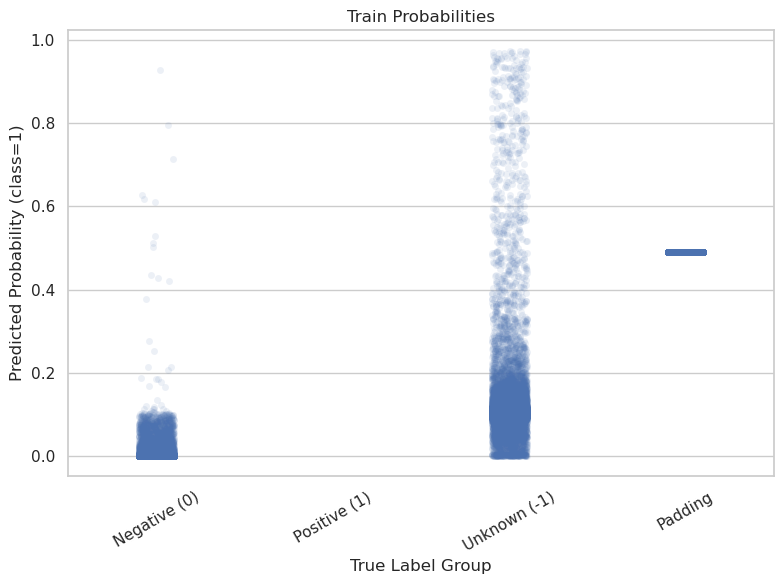

In [37]:
plot_probability_boxplots(best_model, test_loader, DEVICE, num_batches=3, title="Train Probabilities")

In [ ]:
protein_id_species_map = df_genome[["protein_id", "species"]].dropna().set_index("protein_id").to_dict()

In [ ]:
df_cluster = pd.read_csv(cluster_path, sep = "\t", header = None)

In [ ]:
df_cluster.columns = ["cluster", "protein"]

In [ ]:
df_cluster["species"] = df_cluster.protein.map(protein_id_species_map["species"])

In [ ]:
df_cluster.head()

In [ ]:
cluster_enrichment = df_cluster.groupby("cluster").agg({"species": lambda x: len(set(x))})

In [ ]:
vals = cluster_enrichment.sort_values("species", ascending = False)["species"].values

In [ ]:
cluster_enrichment["core"] = cluster_enrichment.species.apply(lambda x: 1 if x > 300 else 0)

In [ ]:
df_cluster["core"] = df_cluster.cluster.map(cluster_enrichment.to_dict()["core"])

In [ ]:
300/1950

In [ ]:
df_cluster.core.sum()

In [ ]:
df_genome_notna = df_genome[df_genome.protein_id.notna()]

In [ ]:
cluster_species_map = df_genome_notna.groupby("cluster").agg({"species": lambda x: len(set(x))})

In [ ]:
df_genome["protein_cluster"] = df_genome["protein_id"].map(df_cluster.drop_duplicates("protein").\
                                                           set_index("protein")["cluster"])

In [ ]:
df_genome.columns

In [ ]:
df_genome["species_prev"] = df_genome["protein_cluster"].map(cluster_species_map.to_dict()["species"], \
                                                            na_action = "ignore")

In [ ]:
df_acc = pd.read_csv("/orange/sai.zhang/khoa/repos/prophage/data/genome_db_accessory.csv")

In [ ]:
df_acc.feature_id

In [ ]:
df_acc.head()

In [ ]:
df_acc.feature_id.head()

In [ ]:
df_genome_full = df_genome.merge(df_acc[["feature_id", "strand", "locus_tag"]].copy(), on = "feature_id", how = "left")

In [ ]:
df_genome_full.to_csv("/orange/sai.zhang/khoa/repos/prophage/data/isolate_db_full.csv", index = None)

In [ ]:
df_temp = df_genome.dropna(subset= ["homologs", "species_prev"])

In [ ]:
df_temp[(df_temp.homologs > 3000) & (df_temp.species_prev < 250)]["product"].unique()

In [ ]:
df_genome[(df_genome["product"] == "hypothetical protein") & (df_genome["species_prev"] > 1000)]

In [ ]:
df_temp[df_temp["product"]]

In [ ]:
plt.scatter(df_temp.homologs.values, df_temp.species_prev.values)

In [ ]:
df_genome_notna["species_prev"] = df_genome_notna.groupby("cluster").agg({"species": lambda x: len(set(x))})

In [ ]:
df_genome_notna["cluster"] = df_genome_notna.protein_id.map(\
                            df_cluster.drop_duplicates("protein").set_index("protein")["cluster"])

In [ ]:
df_prophage = df_genome_notna[df_genome_notna.prophage == 1]

In [ ]:
df_temp = df_prophage.groupby("cluster").agg({"species": lambda x: len(set(x))})

In [ ]:
df_prophage[df_prophage.cluster == "WZV03482.1"]

In [ ]:
df_temp.sort_values("species", ascending = False)

In [ ]:
plt.boxplot(df_temp["species"])
plt.show()

In [ ]:
np.quantile(df_genome[df_genome.prophage == 1].homologs.dropna(), 0.95)

In [ ]:
df_genome[(df_genome.prophage == 1) & (df_genome.homologs > 1000)]

In [ ]:
plt.boxplot(df_genome[df_genome.prophage == 1].homologs.dropna())
plt.show()

In [ ]:
df_genome[df_genome.prophage == 1].homologs.hist(bins = 100)

In [ ]:
sum(vals[np.where(vals > 200)])

In [ ]:
plt.plot(vals, marker = ".")

In [ ]:
db.get_record_feature(all_record_ids[0])

df_genome = db.get_genome_table()

len(df_genome.feature_id.unique())

In [ ]:
dnaEmbeddings.get_embeddings(['NZ_CP053030.1'], ['WP_010428490.1'])

In [ ]:
species_phage = df_genome.groupby("species").agg({"prophage":"sum"})

In [ ]:
species_phage[species_phage["prophage"] == 0]

In [ ]:
species_phage.hist(bins = 100)

In [ ]:
db.get_record_feature(all_record_ids[1000])

In [ ]:
df_genome = db.get_genome_table()

In [ ]:
prophage_taxa_map =  db.get_taxonomy()

In [ ]:
length = df_genome.groupby("record_id").count()

In [ ]:
shorties = df_genome[df_genome.record_id.isin(length[length.feature_id < 100].index)].\
groupby("record_id").agg({"product":list, "species":"first", "prophage": "max"})

In [ ]:
df_temp = df_genome.dropna(subset = ["product"])

In [ ]:
df_temp[df_temp["product"].str.contains("reverse") & ~df_temp["product"].str.contains("intron")].groupby("homologs").agg(list)

In [ ]:
df_temp = shorties.groupby("species").agg({"product":list, "prophage":list})

In [ ]:
db.get_product([i for i in list(db.get_viral_element("GCF_027625935.1").values())[1]])

In [ ]:
list(db.get_viral_element("GCF_027625935.1"))

In [ ]:
df_temp[df_temp.prophage == 1]["product"]

In [ ]:
length[length.feature_id < 10]

In [ ]:
df_genome.groupby("record_id").count()

In [ ]:
length.max()

In [ ]:
df_genome.groupby("record_id").count()["feature_id"].hist(bins = 100)

In [ ]:
all_viral_embeddings = []
all_viral_embeddings_pooled = []
all_taxa = []
all_seq_names = []
for seq_name, proteins in vp.items():
    # print(seq_name)
    protein_clean = [p for p in proteins if p]
    protein_embeddings, _ = proteinEmbeddings.get_embeddings(protein_clean)
    if (np.isnan(protein_embeddings).sum()) > 0 or (np.isnan(protein_embeddings.mean(axis = 0)).sum() > 0):
        print(seq_name)
        continue
    all_viral_embeddings_pooled.append(protein_embeddings.mean(axis = 0))
    all_viral_embeddings.append(protein_embeddings)
    all_taxa.append(prophage_taxa_map[seq_name])
    all_seq_names.append(seq_name)

In [ ]:
def fast_umap(array):
    umap = UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='euclidean', random_state=42)
    pca = PCA(n_components=100)
    scaler = StandardScaler()
    print(array.shape)
    cp_array = cp.asarray(array)
    cp_array = scaler.fit_transform(cp_array)
    cp_array = pca.fit_transform(cp_array)
    cp_array = umap.fit_transform(cp_array)
    return cp_array.get()

In [ ]:
all_viral_embeddings_pooled_arr = np.array(all_viral_embeddings_pooled)

In [ ]:
umap_embeddings = fast_umap(all_viral_embeddings_pooled_arr)

In [ ]:
df_vclust = pd.read_csv(vclust_path, sep = "\t")

In [ ]:
df_vclust["count"] = df_vclust.cluster.map(df_vclust.groupby("cluster").count().to_dict()["object"])

In [ ]:
df_vclust["label"] = (
    df_vclust["cluster"]
      .where(df_vclust["count"] > 5, other=-1)
)

In [ ]:
df_merged = pd.DataFrame(all_seq_names).merge(df_vclust, left_on=0, right_on="object", how="left")

In [ ]:
df_merged["label"] = df_merged.label.fillna(-1)

In [ ]:
df_vclust["object"] = pd.Categorical(df_vclust["object"],
                             categories=all_seq_names,
                             ordered=True)
df_vclust = df_vclust.sort_values("object")

In [ ]:
len(df_merged)

In [ ]:
df_umap[(df_umap[1] > 10)]

In [ ]:
df_umap[(df_umap[0] < -5)]

In [ ]:
df_umap = pd.DataFrame(umap_embeddings)

In [ ]:
df_selected = df_umap[(df_umap[0] < -5) & (df_umap[1] > 10)]

In [ ]:
selected_phage = [all_seq_names[i] for i in df_selected.index]

In [ ]:
df_virome = db.get_virome_table()

In [ ]:
df_genome = db.get_genome_table()

In [ ]:
df_genome.head()

In [ ]:
df_virome.species.unique()

In [ ]:
df_species = db.get_species("GCF_030296915.1")

In [ ]:
plt.plot(df_species.homologs.fillna(0))
plt.plot(df_species.prophage*-8000)

In [ ]:
df_test = pd.DataFrame(list(db.get_viral_element("GCF_029689965.1", "all").values())[0])

In [ ]:
df_test.sort_values("homologs", ascending = False)

In [ ]:
db.get_product(list(db.get_viral_element("GCF_003797775.2").values())[0])["product"].to_list()

In [ ]:
df_virome[df_virome["seq_name"].isin(selected_phage)]

In [ ]:
plt.scatter(df_selected[0], df_selected[1])

In [ ]:
k = 20
km_gpu = faiss.Kmeans(
    d=all_viral_embeddings_pooled_arr.shape[1],
    k=k,
    niter=20,
    verbose=True,
    gpu=True,
)
km_gpu.train(all_viral_embeddings_pooled_arr)

In [ ]:
agg = AgglomerativeClustering(n_clusters=20, linkage='single')

In [ ]:
all_viral_embeddings_pooled_arr.shape

In [ ]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Sample data: 10 observations with 4 features
np.random.seed(42)
X = all_viral_embeddings_pooled_arr
# Compute hierarchical clustering using Ward's method
Z = linkage(X, method='ward')

In [ ]:
# Extract cluster labels given a height threshold
num_labels = []
for thresh in range(10, 100, 2):
    labels = fcluster(Z, t=thresh, criterion='distance')
    num_labels.append(len(Counter(labels)))
    # print("Cluster labels at threshold", threshold, ":\n", labels)
    # print("Num cluster", len(Counter(labels)))
    # print("Count", Counter(labels))

In [ ]:
plt.plot(range(10, 100, 2), num_labels, marker = "o")

In [ ]:
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from collections import Counter
from matplotlib import cm
from matplotlib.colors import to_hex
import plotly.io as pio
pio.renderers.default = "jupyterlab" 
# ---- Replace with your real data ----
# X: 2D array of shape (n_samples, n_features)
X = all_viral_embeddings_pooled_arr  
# seq_names: list of sequence IDs in the same order as X
seq_names = all_seq_names  
# Mapping from sequence ID to taxon
taxa_map = prophage_taxa_map  

# ---- Parameters ----
threshold = 25

# Determine the major (most common) taxon
taxa_list_full = [taxa_map[name] for name in seq_names]
major_taxon = Counter(taxa_list_full).most_common(1)[0][0]

# Create interactive dendrogram
dendro = ff.create_dendrogram(
    X, 
    orientation='left', 
    labels=seq_names, 
    color_threshold=threshold
)
# Extract leaf order from dendrogram
leaves = dendro.layout.yaxis.ticktext

# Prepare taxa list ordered by leaves
taxa_list = [taxa_map[name] for name in leaves]
unique_taxa = sorted(set(taxa_list))

# Build a discrete color map, forcing major_taxon to white
cmap = cm.get_cmap('Set3', len(unique_taxa))
taxa_color_map = {}
for i, t in enumerate(unique_taxa):
    taxa_color_map[t] = 'white' if t == major_taxon else cmap(i)

unique_taxa = sorted(taxa_color_map.keys())
colorscale = []
n = len(unique_taxa)
for i, t in enumerate(unique_taxa):
    frac = i / (n - 1) if n > 1 else 0
    hexcol = to_hex(taxa_color_map[t])
    colorscale.append([frac, hexcol])

# Then, when you create the heatmap:
heatmap = go.Heatmap(
    z=z,
    x=['Taxa'],
    y=leaves,
    colorscale=colorscale,   # now a list of [fraction, '#rrggbb']
    showscale=False,
    hoverinfo='y+z'
)

# Create subplot: dendrogram + taxa track
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.85, 0.15],
    shared_yaxes=True,
    horizontal_spacing=0
)

# Add dendrogram traces to col 1
for trace in dendro.data:
    fig.add_trace(trace, row=1, col=1)

# Add taxa heatmap to col 2
heatmap = go.Heatmap(
    z=z,
    x=['Taxa'],
    y=leaves,
    colorscale=colorscale,
    showscale=False,
    hoverinfo='y+z'
)
fig.add_trace(heatmap, row=1, col=2)

# Update layout
fig.update_layout(
    title="Hierarchical Clustering Dendrogram with Interactive Taxa Track",
    width=1000,
    height=800,
    showlegend=False
)
# Hide axis labels for taxa column
fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_yaxes(showticklabels=False, row=1, col=2)

# Draw cutoff line manually
# (Plotly create_dendrogram doesn't auto-draw threshold)
fig.add_shape(
    type="line",
    x0=threshold, x1=threshold,
    y0=0, y1=len(leaves)*10,
    line=dict(color="black", dash="dash"),
    xref='x1', yref='y1'
)

fig.show()


In [ ]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch

# ---- Replace with your real data ----
np.random.seed(0)
X = all_viral_embeddings_pooled_arr
Z = linkage(X, method='ward')

# ---- Parameters ----
threshold = 25
taxa  = [prophage_taxa_map[seq] for seq in all_seq_names]
major_taxon = Counter(taxa).most_common(1)[0][0]
# Build discrete colormap for taxa
unique_taxa = sorted(set(taxa))
cmap = cm.get_cmap('tab20', len(unique_taxa))
taxa_color_map = {t: cmap(i) for i, t in enumerate(unique_taxa)}
for i, t in enumerate(unique_taxa):
    if t == major_taxon:
        taxa_color_map[t] = 'white'
    else:
        taxa_color_map[t] = cmap(i)
# Dynamic figure sizing
fig_height = n_samples * 0.005
fig_width = 20

# Plot dendrogram
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ddata = dendrogram(
    Z,
    color_threshold=threshold,
    no_labels=True,
    orientation='left',
    ax=ax
)

# Customize plot
ax.set_title('Hierarchical Clustering Dendrogram of Pooled Protein Embeddings with geNomad taxa', pad=20)
ax.set_xlabel('Distance')
ax.axvline(x=threshold, linestyle='--', linewidth=1, label=f'Cutoff @ {threshold}')

# Leaf positions
leaves = ddata['leaves']
leaf_positions = np.arange(len(leaves)) * 10 + 5

# Bar placement on the right
xmin, xmax = ax.get_xlim()
bar_width = (xmax - xmin) * 0.1
x_start = xmax + bar_width * 0.2
ax.set_xlim(xmin, x_start + bar_width * 1.2)

# Draw colored bars with no edge color
bar_height = 9
for y_pos, leaf_idx in zip(leaf_positions, leaves):
    taxon = taxa[leaf_idx]
    ax.barh(
        y=y_pos,
        width=bar_width,
        left=x_start,
        height=bar_height,
        color=taxa_color_map[taxon],
        edgecolor='none',
        linewidth=0
    )

# Clean up
ax.set_yticks([])
legend_handles = [Patch(facecolor=taxa_color_map[t], label=t) for t in unique_taxa]
ax.legend(
    handles=legend_handles,
    title='Taxa',
    loc='center',
    bbox_to_anchor=(0, 0),
    borderaxespad=0, 
    fontsize='medium',        # smaller font for labels
    title_fontsize='medium',  # smaller font for title
    handlelength=1,          # shorter color swatches
    handletextpad=0.5        # tighter spacing
)

plt.tight_layout()
plt.savefig("dendrogram.png", dpi = 1000)
plt.show()

# Flat cluster labels
labels = fcluster(Z, t=threshold, criterion='distance')
print("Cluster labels at threshold", threshold, ":\n", labels[:10], "... total", len(labels))



In [ ]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

threshold = 25
plt.figure(figsize = (4,10))
dendrogram(
    Z,
    color_threshold=threshold,
    no_labels=True,
    orientation='left'
)
plt.title('Hierarchical Clustering Dendrogram of Pooled Embeddings')
plt.xlabel('Distance')
plt.axvline(x=threshold, linestyle='--', linewidth=1, label=f'Cutoff @ {threshold}')
plt.legend()
plt.yticks([])
plt.show()

taxa  = [prophage_taxa_map[seq] for seq in all_seq_names]
# plot taxa next to each leaf, color code taxa

In [ ]:
labels = agg.fit_predict(all_viral_embeddings_pooled_arr)

In [ ]:
labels = [prophage_taxa_map[seq] for seq in all_seq_names]
# labels = df_merged.label
# labels = list(km_gpu.assign(all_viral_embeddings_pooled_arr)[1])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

# — assume these are defined —
# umap_embeddings: np.ndarray, shape (n_samples, 2)
# all_taxa        : List[str],   length = n_samples

# 1) Turn labels into integer codes + compute abundances
taxa_cat     = pd.Categorical(labels)
codes        = taxa_cat.codes                   # ints 0 … n_categories-1
labels       = taxa_cat.categories              # unique taxa
n_categories = len(labels)

counts       = pd.Series(codes).value_counts()
codes_sorted = counts.index.tolist()            # sorted by abundance desc

# 2) Grab a Set2 palette with exactly one distinct color per class
palette = sns.color_palette("Set3", n_colors=n_categories)
cmap    = ListedColormap(palette)
norm    = BoundaryNorm(np.arange(n_categories+1)-0.5, n_categories)

# 3) Plot styling
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.figure(figsize=(8, 6))

# 4) Plot each class in abundance order (largest first, rarest last)
for z, code in enumerate(codes_sorted):
    mask = (codes == code)
    # Optionally make majority fainter
    if z == 0:
        s, alpha = 20, 0.3
    else:
        s, alpha = 80, 0.85

    plt.scatter(
        umap_embeddings[mask, 0],
        umap_embeddings[mask, 1],
        c=[palette[code]],
        s=s,
        alpha=alpha,
        marker="o",
        edgecolor="k",
        linewidth=0.3,
        label=str(labels[code]),
        zorder=z
    )

# 5) Legend (in the same abundance order)
handles = [
    Line2D([], [], marker="o", linestyle="",
           markersize=8,
           markerfacecolor=palette[i],
           markeredgecolor="k", markeredgewidth=0.3,
           alpha=(0.3 if i == codes_sorted[0] else 0.85))
    for i in codes_sorted
]
plt.legend(
    handles,
    [labels[i] for i in codes_sorted],
    title="Taxonomy",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.
)

# 6) Final polish
plt.title("UMAP Projection of Pooled Viral Protein Embeddings", fontsize=16, pad=12)
plt.xlabel("UMAP 1", fontsize=14, labelpad=8)
plt.ylabel("UMAP 2", fontsize=14, labelpad=8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(trim=True)
# plt.tight_layout()
plt.savefig("pooled_virus.png")
plt.show()


In [ ]:
import numpy as np
import cupy as cp

In [ ]:
species_embeddings, _ = proteinEmbeddings.get_embeddings(protein_ids=all_proteins_ids)

In [ ]:
mean_middle_embeddings_cp = cp.asarray(species_embeddings)

In [ ]:
umap = UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine', random_state=42)

In [ ]:
scaler = StandardScaler()

In [ ]:
embedding_scaled = scaler.fit_transform(mean_middle_embeddings_cp)

In [ ]:
embedding_pca = PCA(n_components=100).fit_transform(embedding_scaled)

In [ ]:
umap_embedding = umap.fit_transform(embedding_pca)

In [ ]:
umap_embedding_np = umap_embedding.get()

In [ ]:
plt.scatter(embedding_pca[:,0].get(), embedding_pca[:,1].get(), marker = ".", alpha = .3, c = labels, cmap = "Set2")
plt.show()

In [ ]:
plt.scatter(umap_embedding_np[:,0], umap_embedding_np[:,1],\
            marker = ".", alpha =0.8 , c=labels, cmap="Set2")
plt.show()

In [ ]:
res = faiss.StandardGpuResources()         # initialize GPU resources

In [ ]:
embeddings = mean

In [ ]:
km_gpu.assign(all_viral_embeddings_pooled_arr)

In [ ]:
help(HDBSCAN)

In [ ]:
model = HDBSCAN(
    min_cluster_size=5,
    metric='euclidean',
    gen_min_span_tree =True
)

In [ ]:
labels = model.fit_predict(all_viral_embeddings_pooled_arr)

In [ ]:
model.minimum_spanning_tree_.plot()

In [ ]:
from collections import Counter
Counter(labels)